In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# from graphIO import read_ppmi_data
import numpy as np
import sys
sys.path.append('C:/Users/mosta/OneDrive - UNCG\Academics/CSC 699 - Thesis/repos/brain_connectome/graphIO')
from graphIO import read_ppmi_data
from asymmetry import calculate_inter_hemispheric_asymmetry_vector
from sklearn.cross_decomposition import CCA

import matplotlib.pyplot as plt

In [54]:
PPMI_DIR = "C:/Users/mosta/OneDrive - UNCG/Academics/CSC 699 - Thesis/data/ppmi"

In [55]:
ppmi_data = read_ppmi_data(PPMI_DIR)

Processing directories:   0%|          | 0/209 [00:00<?, ?it/s]

Processing directories: 100%|██████████| 209/209 [00:01<00:00, 141.35it/s]


In [56]:
control_matrices = np.array([ppmi_data['sub-control'][i] for i in ppmi_data['sub-control']])
patient_matrices = np.array([ppmi_data['sub-patient'][i] for i in ppmi_data['sub-patient']])
prodromal_matrices = np.array([ppmi_data['sub-prodromal'][i] for i in ppmi_data['sub-prodromal']])
swedd_matrices = np.array([ppmi_data['sub-swedd'][i] for i in ppmi_data['sub-swedd']])
connectivity_matrices = np.concatenate((control_matrices, patient_matrices, prodromal_matrices, swedd_matrices), axis=0)
connectivity_matrices = (connectivity_matrices - np.min(connectivity_matrices)) / (np.max(connectivity_matrices) - np.min(connectivity_matrices))
print(connectivity_matrices.shape)

(209, 116, 116)


In [68]:
# Define the VAE model
class CurvatureVAE(nn.Module):
    def __init__(self, input_shape=(1, 116, 116), hidden_dim=256, latent_dim=1):
        super(CurvatureVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(116 * 116 * 64, hidden_dim),
            nn.ReLU()
        )
        self.fc1 = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 116 * 116 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 116, 116)),
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc1(h), self.fc2(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = self.fc3(z)
        return self.decoder(h3)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [69]:
# Normalize the data
# Alternatively, you can standardize the data
# patient_matrices = (patient_matrices - np.mean(patient_matrices)) / np.std(patient_matrices)
connectivity_tensor = connectivity_matrices.reshape((-1, 116, 116))  # Ensure the shape is correct
connectivity_tensor = torch.tensor(connectivity_matrices, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(connectivity_tensor, connectivity_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training the VAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patients_model = CurvatureVAE().to(device)
patients_optimizer = optim.Adam(patients_model.parameters(), lr=1e-4)

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

def calculate_mse(dataloader, model):
    model.eval()
    mse_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon, _, _ = model(data)
            mse_loss += nn.functional.mse_loss(recon, data, reduction='sum').item()
    return mse_loss / len(dataloader.dataset)

num_epochs = 20
for epoch in range(1, num_epochs + 1):
    patients_model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        patients_optimizer.zero_grad()
        recon_batch, mu, logvar = patients_model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(patients_model.parameters(), max_norm=1.0)
        train_loss += loss.item()
        patients_optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    avg_train_loss = train_loss / len(dataloader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')
    
    # Calculate validation MSE
    val_mse = calculate_mse(dataloader, patients_model)
    print(f'====> Validation MSE after Epoch {epoch}: {val_mse:.4f}')


Train Epoch: 1 [0/209 (0%)]	Loss: 1687.924683
====> Epoch: 1 Average loss: 1453.0468
====> Validation MSE after Epoch 1: 762.6205
Train Epoch: 2 [0/209 (0%)]	Loss: 780.801941
====> Epoch: 2 Average loss: 636.2700
====> Validation MSE after Epoch 2: 587.5615
Train Epoch: 3 [0/209 (0%)]	Loss: 609.688416
====> Epoch: 3 Average loss: 659.5581
====> Validation MSE after Epoch 3: 549.6723
Train Epoch: 4 [0/209 (0%)]	Loss: 554.910828
====> Epoch: 4 Average loss: 809.4926
====> Validation MSE after Epoch 4: 560.0835
Train Epoch: 5 [0/209 (0%)]	Loss: 560.615723
====> Epoch: 5 Average loss: 548.4550
====> Validation MSE after Epoch 5: 503.8257
Train Epoch: 6 [0/209 (0%)]	Loss: 495.650757
====> Epoch: 6 Average loss: 513.6098
====> Validation MSE after Epoch 6: 497.4995
Train Epoch: 7 [0/209 (0%)]	Loss: 498.472290
====> Epoch: 7 Average loss: 503.5422
====> Validation MSE after Epoch 7: 492.4766
Train Epoch: 8 [0/209 (0%)]	Loss: 478.718903
====> Epoch: 8 Average loss: 499.2276
====> Validation MS

In [70]:
print(control_matrices.shape, patient_matrices.shape)

(15, 116, 116) (113, 116, 116)


In [71]:
# Function to get the latent space representation
def get_latent_space(model, data_vector, use_mean=True):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        # Ensure the data is in the correct shape and tensor format
        data_tensor = torch.tensor(data_vector.reshape(1, 1, 116, 116), dtype=torch.float32).to(device)
        # Pass through the encoder to get mu and logvar
        mu, logvar = model.encode(data_tensor)
        if use_mean:
            return mu.cpu().numpy()  # Return the mean as the latent representation
        else:
            # Sample from the distribution using reparameterization trick
            z = model.reparameterize(mu, logvar)
            return z.cpu().numpy()  # Return the sampled latent representation

In [ ]:
from sklearn.cross_decomposition import CCA
latent_space_1 = np.array([get_latent_space(asymm_vae, vec) for vec in control_asymm_vectors]).reshape((-1, 100))
latent_space_2 = np.array([get_latent_space(asymm_vae, vec) for vec in patient_asymm_vectors])[:len(latent_space_1)].reshape((-1,100))
print(latent_space_1.shape, latent_space_2.shape)
cca = CCA(n_components=2)
cca_latent_1, cca_latent_2 = cca.fit_transform(latent_space_1, latent_space_2)

In [73]:
control_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix) for matrix in control_matrices])
patient_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix) for matrix in patient_matrices])
prodromal_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix) for matrix in prodromal_matrices])
swedd_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(matrix) for matrix in swedd_matrices])
print(control_asymm_vectors.shape, patient_asymm_vectors.shape, prodromal_asymm_vectors.shape, swedd_asymm_vectors.shape)

(15, 58) (113, 58) (67, 58) (14, 58)


In [75]:
tensors = {}
tensors['control'] = torch.tensor(control_asymm_vectors.reshape((-1, 1, 58)), dtype=torch.float32).unsqueeze(1)
tensors['patient'] = torch.tensor(patient_asymm_vectors.reshape((-1, 1, 58)), dtype=torch.float32).unsqueeze(1)
tensors['prodromal'] = torch.tensor(prodromal_asymm_vectors.reshape((-1, 1, 58)), dtype=torch.float32).unsqueeze(1)
tensors['swedd'] = torch.tensor(swedd_asymm_vectors.reshape((-1, 1, 58)), dtype=torch.float32).unsqueeze(1)

In [98]:
class AsymmetryVAE(nn.Module):
    def __init__(self, input_shape=(1, 1, 58), hidden_dim=256, latent_dim=100):
        super(AsymmetryVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # Assuming a small convolution kernel
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the flattened size after convolution
        self.flattened_size = 64 * 1 * 58
        
        self.fc1 = nn.Linear(self.flattened_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, self.flattened_size)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 1, 58)),
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        h = torch.relu(self.fc1(h))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc4(z))
        h = torch.relu(self.fc5(h))
        h = self.decoder(h)
        return h
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [99]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

def calculate_mse(dataloader, model):
    model.eval()
    mse_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon, _, _ = model(data)
            mse_loss += nn.functional.mse_loss(recon, data, reduction='sum').item()
    return mse_loss / len(dataloader.dataset)

In [100]:
num_epochs = 100
laten_space_dim = 58
models = {}
optimizers = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for group in ['control', 'patient', 'prodromal', 'swedd']:
    models[group] = AsymmetryVAE(latent_dim=laten_space_dim).to(device)
    optimizers[group] = optim.Adam(models[group].parameters(), lr=1e-4)
    dataset = TensorDataset(tensors[group], tensors[group])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Training model for group: {group}')
    for epoch in range(1, num_epochs + 1):
        models[group].train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizers[group].zero_grad()
            recon_batch, mu, logvar = models[group](data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(models[group].parameters(), max_norm=1.0)
            train_loss += loss.item()
            optimizers[group].step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
        avg_train_loss = train_loss / len(dataloader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}')
        
        # Calculate validation MSE
        val_mse = calculate_mse(dataloader, models[group])
        print(f'====> Validation MSE after Epoch {epoch}: {val_mse:.4f}')


Training model for group: control
Train Epoch: 1 [0/15 (0%)]	Loss: 15.369124
====> Epoch: 1 Average loss: 15.3691
====> Validation MSE after Epoch 1: 15.1430
Train Epoch: 2 [0/15 (0%)]	Loss: 15.197637
====> Epoch: 2 Average loss: 15.1976
====> Validation MSE after Epoch 2: 14.9784
Train Epoch: 3 [0/15 (0%)]	Loss: 14.911787
====> Epoch: 3 Average loss: 14.9118
====> Validation MSE after Epoch 3: 14.6883
Train Epoch: 4 [0/15 (0%)]	Loss: 14.756147
====> Epoch: 4 Average loss: 14.7561
====> Validation MSE after Epoch 4: 14.5386
Train Epoch: 5 [0/15 (0%)]	Loss: 14.521592
====> Epoch: 5 Average loss: 14.5216
====> Validation MSE after Epoch 5: 14.3783
Train Epoch: 6 [0/15 (0%)]	Loss: 14.343888
====> Epoch: 6 Average loss: 14.3439
====> Validation MSE after Epoch 6: 14.1313
Train Epoch: 7 [0/15 (0%)]	Loss: 14.161011
====> Epoch: 7 Average loss: 14.1610
====> Validation MSE after Epoch 7: 13.8832
Train Epoch: 8 [0/15 (0%)]	Loss: 13.963577
====> Epoch: 8 Average loss: 13.9636
====> Validation M

In [101]:
control_asymm_vector = np.array(calculate_inter_hemispheric_asymmetry_vector(control_matrices.mean(axis=0)))
control_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(mat) for mat in control_matrices])
patient_asymm_vector = np.array(calculate_inter_hemispheric_asymmetry_vector(patient_matrices.mean(axis=0)))
patient_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(mat) for mat in patient_matrices])
prodromal_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(mat) for mat in prodromal_matrices])
swedd_asymm_vectors = np.array([calculate_inter_hemispheric_asymmetry_vector(mat) for mat in swedd_matrices])
print(control_asymm_vector.shape, patient_asymm_vector.shape)
print(control_asymm_vectors.shape, patient_asymm_vectors.shape)


(58,) (58,)
(15, 58) (113, 58)


In [102]:
# Function to get the latent space representation
def get_latent_space(model, data_vector, use_mean=True):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients
        # Ensure the data is in the correct shape and tensor format
        data_tensor = torch.tensor(data_vector.reshape(1, 1, 1, 58), dtype=torch.float32).to(device)
        # Pass through the encoder to get mu and logvar
        mu, logvar = model.encode(data_tensor)
        if use_mean:
            return mu.cpu().numpy()  # Return the mean as the latent representation
        else:
            # Sample from the distribution using reparameterization trick
            z = model.reparameterize(mu, logvar)
            return z.cpu().numpy()  # Return the sampled latent representation

In [116]:
data_control = control_asymm_vectors[:14]
data_patient = patient_asymm_vectors[:14]
data_prodromal = prodromal_asymm_vectors[:14]
data_swedd = swedd_asymm_vectors[:14]

In [117]:
# Assuming data_class_1 and data_class_2 are your input datasets
cca = CCA(n_components=2)
cca_input_1, cca_input_2 = cca.fit_transform(data_control, data_patient)

correlations_input = [np.corrcoef(cca_input_1[:, i], cca_input_2[:, i])[0, 1] for i in range(cca_input_1.shape[1])]
print("Canonical Correlations on Input:", correlations_input)

Canonical Correlations on Input: [1.0, 1.0]


In [118]:
latent_space_1 = np.array([get_latent_space(models['control'], vec) for vec in data_control]).reshape((-1, laten_space_dim))
latent_space_2 = np.array([get_latent_space(models['patient'], vec) for vec in data_patient]).reshape((-1,laten_space_dim))
latent_space_3 = np.array([get_latent_space(models['prodromal'], vec) for vec in data_prodromal]).reshape((-1,laten_space_dim))
latent_space_4 = np.array([get_latent_space(models['swedd'], vec) for vec in data_swedd]).reshape((-1,laten_space_dim))
print(latent_space_1.shape, latent_space_2.shape)
cca = CCA(n_components=2)
cca_latent_1, cca_latent_2 = cca.fit_transform(latent_space_1, latent_space_2)
cca_latent_1, cca_latent_3 = cca.fit_transform(latent_space_1, latent_space_3)
cca_latent_1, cca_latent_4 = cca.fit_transform(latent_space_1, latent_space_4)

(14, 58) (14, 58)


In [119]:
print(cca_latent_1)

[[ 0.39400762 -0.66550907]
 [ 2.33866036  1.0295661 ]
 [-0.89477407 -1.12286109]
 [-0.41058593  2.12536989]
 [-0.21418078  1.45974512]
 [ 0.06892577 -0.56365622]
 [-0.58885708  0.13393077]
 [-1.23520193 -1.83200346]
 [-0.32078262  1.11990008]
 [-0.37468809 -0.91470025]
 [ 1.31758764 -0.15187285]
 [ 0.411748   -1.21224475]
 [ 1.43720194 -0.66777496]
 [-1.92906073  1.26211071]]


In [120]:
correlations_latent = [np.corrcoef(cca_latent_1[:, i], cca_latent_2[:, i])[0, 1] for i in range(cca_latent_1.shape[1])]
print("Canonical Correlations:", correlations_latent)

Canonical Correlations: [-0.6009226719518578, 0.4716677665041615]


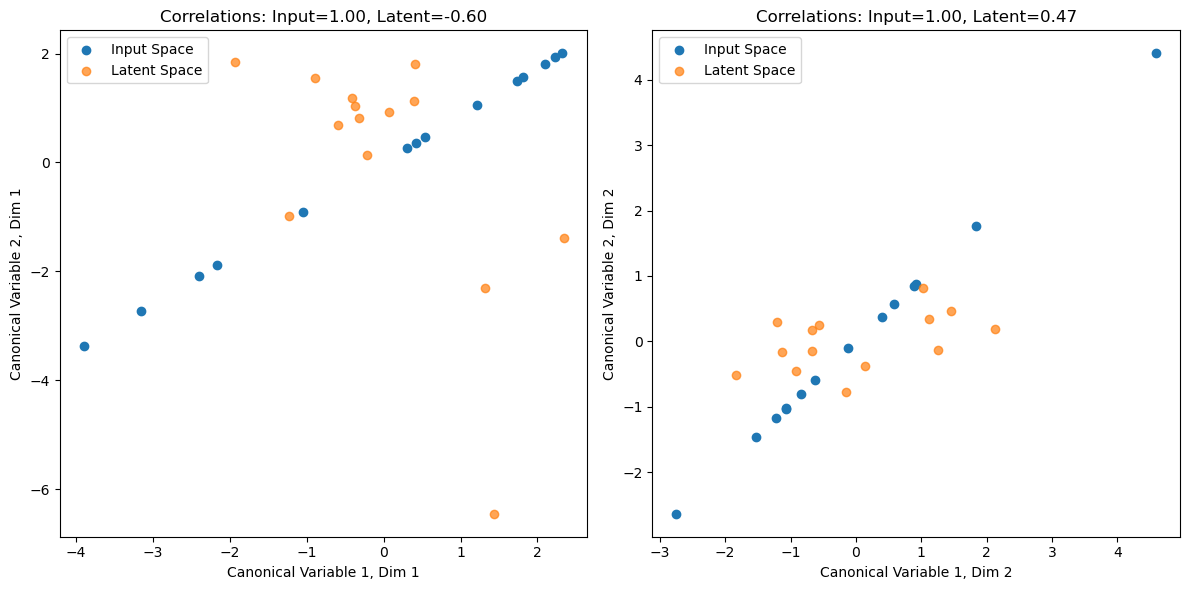

In [121]:
plt.figure(figsize=(12, 6))
for i in range(2):  # Assuming n_components=2
    plt.subplot(1, 2, i + 1)
    plt.scatter(cca_input_1[:, i], cca_input_2[:, i], label='Input Space')
    plt.scatter(cca_latent_1[:, i], cca_latent_2[:, i], label='Latent Space', alpha=0.7)
    plt.xlabel(f'Canonical Variable 1, Dim {i+1}')
    plt.ylabel(f'Canonical Variable 2, Dim {i+1}')
    plt.title(f'Correlations: Input={correlations_input[i]:.2f}, Latent={correlations_latent[i]:.2f}')
    plt.legend()
plt.tight_layout()
plt.show()

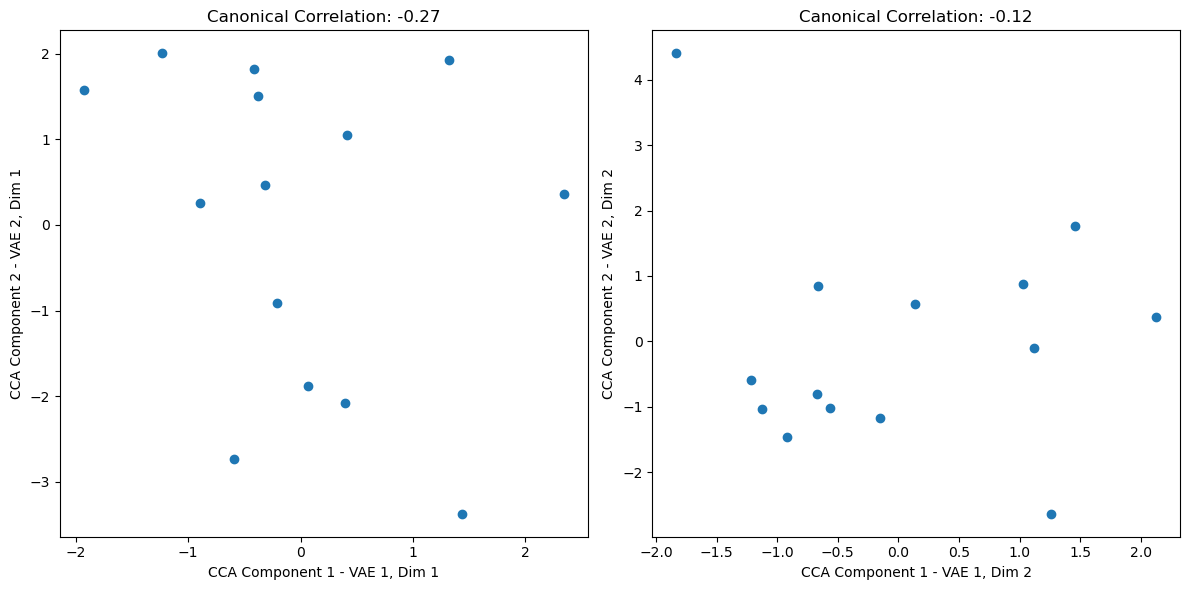

In [112]:


plt.figure(figsize=(12, 6))
for i in range(cca_latent_1.shape[1]):
    plt.subplot(1, cca_latent_1.shape[1], i + 1)
    plt.scatter(cca_latent_1[:, i], cca_latent_2[:, i])
    plt.xlabel(f'CCA Component 1 - VAE 1, Dim {i+1}')
    plt.ylabel(f'CCA Component 2 - VAE 2, Dim {i+1}')
    plt.title(f'Canonical Correlation: {correlations[i]:.2f}')
plt.tight_layout()
plt.show()

In [113]:
# Loadings for the first canonical variable
loadings_1 = cca.x_loadings_[:, 0]
loadings_2 = cca.y_loadings_[:, 0]

print("Loadings for Class 1:", loadings_1)
print("Loadings for Class 2:", loadings_2)

# Identify top contributing features
top_features_class_1 = np.argsort(np.abs(loadings_1))[-5:]
top_features_class_2 = np.argsort(np.abs(loadings_2))[-5:]

print("Top contributing features for Class 1:", top_features_class_1)
print("Top contributing features for Class 2:", top_features_class_2)

Loadings for Class 1: [ 0.27069124  0.2901005  -0.25778429  0.34119385  0.05037437 -0.31534873
  0.0871954  -0.100217    0.20003306  0.00856312  0.07327203  0.34178126
 -0.17815234  0.39087199  0.12613759  0.01298682 -0.02714266  0.13335278
  0.08393439 -0.18780939  0.40515751 -0.07032094  0.17600635  0.06923614
  0.18540921 -0.4306412  -0.26081424 -0.16815224 -0.00868718  0.15204923
  0.19598285  0.30728893 -0.03645605 -0.00852056  0.06401002  0.01308144
 -0.08643668  0.1371721  -0.15904644  0.14074088 -0.18796642  0.06080537
 -0.33977256 -0.30594245 -0.30729519  0.03638217  0.13799107  0.38865867
 -0.09504563 -0.16831486 -0.33807482  0.15624839  0.37251157  0.04678093
 -0.2848721   0.16132455 -0.16907394  0.01208931]
Loadings for Class 2: [ 0.39830645  0.05434663 -0.19227598 -0.18380718  0.12028949 -0.01461795
  0.00740525  0.05759493 -0.13560183 -0.02367148 -0.34008887  0.09483114
  0.22523065 -0.21123539 -0.19677153  0.05987513 -0.21686586  0.03841765
  0.10402842 -0.18070653 -0.05

In [108]:
# Loadings for the first canonical variable
loadings_1 = cca.x_loadings_[:, 0]
loadings_2 = cca.y_loadings_[:, 0]

print("Loadings for Class 1:", loadings_1)
print("Loadings for Class 2:", loadings_2)

# Identify top contributing features
top_features_class_1 = np.argsort(np.abs(loadings_1))[-5:]
top_features_class_2 = np.argsort(np.abs(loadings_2))[-5:]

print("Top contributing features for Class 1:", top_features_class_1)
print("Top contributing features for Class 2:", top_features_class_2)

Loadings for Class 1: [ 0.27069124  0.2901005  -0.25778429  0.34119385  0.05037437 -0.31534873
  0.0871954  -0.100217    0.20003306  0.00856312  0.07327203  0.34178126
 -0.17815234  0.39087199  0.12613759  0.01298682 -0.02714266  0.13335278
  0.08393439 -0.18780939  0.40515751 -0.07032094  0.17600635  0.06923614
  0.18540921 -0.4306412  -0.26081424 -0.16815224 -0.00868718  0.15204923
  0.19598285  0.30728893 -0.03645605 -0.00852056  0.06401002  0.01308144
 -0.08643668  0.1371721  -0.15904644  0.14074088 -0.18796642  0.06080537
 -0.33977256 -0.30594245 -0.30729519  0.03638217  0.13799107  0.38865867
 -0.09504563 -0.16831486 -0.33807482  0.15624839  0.37251157  0.04678093
 -0.2848721   0.16132455 -0.16907394  0.01208931]
Loadings for Class 2: [ 0.39830645  0.05434663 -0.19227598 -0.18380718  0.12028949 -0.01461795
  0.00740525  0.05759493 -0.13560183 -0.02367148 -0.34008887  0.09483114
  0.22523065 -0.21123539 -0.19677153  0.05987513 -0.21686586  0.03841765
  0.10402842 -0.18070653 -0.05